## sensitivity.ipynb
This notebook is to compile key figures and outputs of the sensitivity study on the hydraulic conductivity layer model. 

By Emily Mongold 8 April 2025

In [1]:
# Imports

import numpy as np
import pandas as pd
import geopandas as gpd
from pykrige.ok import OrdinaryKriging
from scipy import stats
from shapely.geometry import Point
import utm
import rasterio
from rasterio.transform import from_bounds
import ruptures as rpt
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as ctx

from ngl_tools import smt

from regional_K.cpt_functions import setup_cpt, calc_SBT, soil_stress, detect_change_points, k_from_Ic, setup_grid, solve_Ic, SBT_from_Ic, ms_layer_assignment, msaf_layer_assignment
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

### Setup

In [2]:

problem = {
    'num_vars': 7,
    'names': ['identification', 'assignment', 'K_source','preprocess','a','b', 't_ref'],  #  
    'bounds': [[0, 2],  # map to heuristic, Hudson2023, change point
               [0, 1], # MS, MS_AF
               [0, 1],  # map to empirical, table
               [0, 1],  # binary, 0 for no preprocessing, 1 for preprocessing
               [0, 2],  # a
               [14,24],  # b
               [3,10]  # t_ref
               ]}

samples = saltelli.sample(problem, 2)
samples = np.round(samples).astype(int)
# Define mappings for Method and K_source
id_mapping = {0: 'heuristic', 1: 'Hudson2023', 2: 'CP'}
assign_mapping = {0: 'MS', 1: 'MS_AF'}
k_source_mapping = {0: 'empirical', 1: 'table'}
categorical_samples = []
for sample in samples:
    id_category = id_mapping[sample[0]]
    assign_category = assign_mapping[sample[1]]
    k_source_category = k_source_mapping[sample[2]]
    translated_sample = [
        id_category,  # identification (categorical)
        assign_category,  # assignment (categorical)
        k_source_category,  # K_source (categorical)
        sample[3],  # preprocess (unchanged)
        sample[4],  # a (unchanged)
        sample[5],  # b (unchanged)
        sample[6]  # t_ref (unchanged)
    ]
    categorical_samples.append(translated_sample)
columns = ['identification', 'assignment', 'K_source','preprocess','a','b', 't_ref']  # 
categorical_samples_df = pd.DataFrame(categorical_samples, columns=columns)
categorical_samples_df.to_csv('./sensitivity_inputs_new_20250114.csv')

# setup the study
shapefile_path = './deposits_shp/sfq2py.shp'
points = setup_grid(geoplot='./geojson/alameda_city.geojson')  # run for just the cases on the island
points['utmX'] = pd.to_numeric(points['utmX'], errors='coerce')
points['utmY'] = pd.to_numeric(points['utmY'], errors='coerce')
points = points.dropna(subset=['utmX', 'utmY'])

cpt = setup_cpt('./USGS_CPT_data/')
## fill any missing water depths with the median
default_dGWT = np.nanmedian([cpt[bh]['Water depth'] for bh in cpt if not np.isnan(cpt[bh]['Water depth'])])
for bh in cpt:
    if np.isnan(cpt[bh]['Water depth']):
        cpt[bh]['Water depth'] = default_dGWT
cpt = soil_stress(cpt)
calc_SBT(cpt)
for _, data in cpt.items():
    data['CPT_data']['I_c'] = solve_Ic(data['CPT_data']['q_c'], data['CPT_data']['sig_v'],data['CPT_data']['sig_prime_v'], data['CPT_data']['f_s'])
    qt_inv, fs_inv, _ = smt.cpt_inverse_filter(np.array(data['CPT_data']['q_c']), np.array(data['CPT_data']['d']), fs=data['CPT_data']['f_s'], sigmav=data['CPT_data']['sig_v'], sigmavp=data['CPT_data']['sig_prime_v'])
    Ic_inv, _, _ = smt.get_Ic_Qtn_Fr(qt_inv, fs_inv, data['CPT_data']['sig_v'],data['CPT_data']['sig_prime_v'])
    data['CPT_data']['I_c_inv'] = Ic_inv
    data['SBT_inv'],_ = SBT_from_Ic(Ic_inv)
    data['k_fromIc_inv'] = k_from_Ic(Ic_inv)
    data['CPT_data']['k_fromIc'] = k_from_Ic(data['CPT_data']['I_c'])

data = gpd.read_file(shapefile_path)
data.crs = 'EPSG:4326'
cpts_df = pd.DataFrame.from_dict(cpt, orient='index')
cpts_df.drop(['CPT_data'], axis=1, inplace=True)
cpts_gdf = gpd.GeoDataFrame(cpts_df, geometry=gpd.points_from_xy(cpts_df['Lon'], cpts_df['Lat']))
cpts_gdf.crs = 'EPSG:4326'
joined = gpd.sjoin(cpts_gdf, data, how='left')

cgs_data = pd.read_csv('./cgs_bhs_0/CGSBoreholeDB_BoreholeLocations.csv')
lith = pd.read_csv('./cgs_bhs_0/lithology.csv')
lith = lith[lith['remarks'].str.contains('fill', case=False, na=False)]
lith = lith.merge(cgs_data[['well_name', 'latitude', 'longitude']], on='well_name', how='left')
lith_gdf = gpd.GeoDataFrame(lith, geometry=gpd.points_from_xy(lith.longitude, lith.latitude),crs='EPSG:4326')
lith_gdf['Fill'] = lith_gdf['bottom_depth'] * 0.3048 # convert to meters
lith = lith[lith.index != 64] ## drop the 64 from the lith data index, it said 'filled' and was not artificial fill.
lith_gdf = lith_gdf[lith_gdf.index != 64]
lith_gdf['UTM -X'], lith_gdf['UTM -Y'] = zip(*[utm.from_latlon(lat, lon)[:2] for lat, lon in zip(lith_gdf['latitude'], lith_gdf['longitude'])])

save_K = pd.DataFrame(index=range(len(categorical_samples)), columns=['hk_m_day_0', 'hk_m_day_1', 'hk_m_day_2', 'hk_m_day_3'])
fill = np.zeros((len(samples),len(points)))
ybm = np.zeros((len(samples),len(points)))
ms = np.zeros((len(samples),len(points)))
print(fill.shape)

for i,sample in enumerate(categorical_samples):
    identification = sample[0]
    assignment = sample[1]
    preprocess = True if sample[3] == 1 else False
    if identification == 'heuristic':
        layers = pd.read_csv('./layer_thicknesses.csv', index_col=0)
        results_k_values = {}
        layers_dict = {}
        for _,row in layers.iterrows():  # [layers['Filename'].str.startswith('ALC')]
            fill_thickness = row['Fill']
            ybm_thickness = row['Young Bay Mud']
            ms_thickness = row['Merrit sand']
            fill_depth = fill_thickness
            ybm_depth = fill_depth + ybm_thickness  # Young Bay Mud goes from fill_depth to fill_depth + ybm_thickness
            ms_depth = ybm_depth + ms_thickness  # Merritt Sand goes from ybm_depth to ybm_depth + ms_thickness
            bh = row['Filename']
            layers_dict[bh] = {'Fill': fill_thickness, 'Young Bay Mud': ybm_thickness, 'Merritt Sand': ms_thickness}
            if bh in cpt:
                if preprocess:
                    results_k_values[bh] = {}
                    fill_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] <= fill_depth)[0]]
                    results_k_values[bh]['Fill'] = fill_values.mean()
                    ybm_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth))[0]]
                    results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() 
                    ms_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth))[0]]
                    results_k_values[bh]['Merritt Sand'] = ms_values.mean() 
                    below_ms_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] > ms_depth)[0]]
                    results_k_values[bh]['Below Merritt Sand'] = below_ms_values.mean()
                else:
                    results_k_values[bh] = {}
                    fill_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] <= fill_depth)]['k_fromIc'].dropna()
                    results_k_values[bh]['Fill'] = fill_values.mean() if not fill_values.empty else 0  # Default to 0 if no data points
                    ybm_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth)]['k_fromIc'].dropna()
                    results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() if not ybm_values.empty else 0  # Default to 0 if no data points
                    ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth)]['k_fromIc'].dropna()
                    results_k_values[bh]['Merritt Sand'] = ms_values.mean() if not ms_values.empty else 0  # Default to 0 if no data points
                    below_ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ms_depth)]['k_fromIc'].dropna()
                    results_k_values[bh]['Below Merritt Sand'] = below_ms_values.mean() if not below_ms_values.empty else 0  # Default to 0 if no data points
        results_k_values = pd.DataFrame(results_k_values).transpose()
        results_k_m_day = results_k_values.apply(lambda x: x*86400)
        log_results_k_df = results_k_m_day.map(lambda x: np.log10(x) if x > 0 else np.nan) 
    elif identification == 'Hudson2023':
        discard_count = 0
        layers_dict = {}
        results_k_values = {}
        for bh in cpt:
            df = cpt[bh]['CPT_data']
            depth = cpt[bh]['CPT_data']['d'].values
            fill_flag = 1 if joined.loc[bh]['PTYPE'] in ['afem','H2O'] else 0
            if preprocess:
                SBT = cpt[bh]['SBT_inv']
                logKh = np.log(cpt[bh]['k_fromIc_inv']*86400).clip(-10)
            else:
                SBT = cpt[bh]['SBT']
                logKh = np.log(df['k_fromIc']*86400).clip(-10)
            ztop, zbot, _, _ = smt.cpt_layering(np.array(SBT), np.array(logKh), depth, tref=sample[6], Nmax=None)
            SBTs = []
            Ks = []
            for indx in range(len(ztop)):
                start_idx = np.where(depth >= ztop[indx])[0][0]
                end_idx = np.where(depth >= zbot[indx])[0][0]
                SBTs.append(stats.mode(SBT[start_idx:end_idx])[0])
                Ks.append(cpt[bh]['CPT_data']['k_fromIc'][start_idx:end_idx].mean())
            depths = zbot - ztop
            if assignment == 'MS':
                layers_dict[bh] = ms_layer_assignment(depths, SBTs, fill_flag)
            elif assignment == 'MS_AF':
                layers_dict[bh] = msaf_layer_assignment(depths, SBTs, fill_flag)
            # layers_dict[bh]['UTM -X'] = cpt[bh]['UTM-X']
            # layers_dict[bh]['UTM -Y'] = cpt[bh]['UTM-Y']
            ## still within borehole and Hudson2023 method
            fill_thickness = layers_dict[bh]['Fill']
            ybm_thickness = layers_dict[bh]['Young Bay Mud']
            ms_thickness = layers_dict[bh]['Merritt Sand']
            fill_depth = fill_thickness  # Fill layer goes from 0 to fill_thickness
            ybm_depth = fill_depth + ybm_thickness  # Young Bay Mud goes from fill_depth to fill_depth + ybm_thickness
            ms_depth = ybm_depth + ms_thickness  # Merritt Sand goes from ybm_depth to ybm_depth + ms_thickness
            if preprocess:
                results_k_values[bh] = {}
                fill_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] <= fill_depth)[0]]
                results_k_values[bh]['Fill'] = fill_values.mean()
                ybm_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth))[0]]
                results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() 
                ms_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth))[0]]
                results_k_values[bh]['Merritt Sand'] = ms_values.mean() 
                below_ms_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] > ms_depth)[0]]
                results_k_values[bh]['Below Merritt Sand'] = below_ms_values.mean()            
            else:
                results_k_values[bh] = {}
                fill_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] <= fill_depth)]['k_fromIc'].dropna()
                results_k_values[bh]['Fill'] = fill_values.mean() if not fill_values.empty else 0  # Default to 0 if no data points
                ybm_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth)]['k_fromIc'].dropna()
                results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() if not ybm_values.empty else 0  # Default to 0 if no data points
                ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth)]['k_fromIc'].dropna()
                results_k_values[bh]['Merritt Sand'] = ms_values.mean() if not ms_values.empty else 0  # Default to 0 if no data points
                below_ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ms_depth)]['k_fromIc'].dropna()
                results_k_values[bh]['Below Merritt Sand'] = below_ms_values.mean() if not below_ms_values.empty else 0  # Default to 0 if no data points
            # Transform data to log scale
        results_k_values = pd.DataFrame(results_k_values).transpose()
        results_k_m_day = results_k_values.apply(lambda x: x*86400)
        log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)
    
    else: # identification == 'CP':
        a = sample[4]
        b = sample[5]

        discard_count = 0
        layers_dict = {}
        results_k_values = {}
        for bh in cpt:
            depth = cpt[bh]['CPT_data']['d']
            sbt = cpt[bh]['SBT']  # ['CPT_data'] && .values for corrected data
            fill_flag = 1 if joined.loc[bh]['PTYPE'] in ['afem','H2O'] else 0
            change_points = detect_change_points(sbt, model="l2", penalty=a*(max(cpt[bh]['CPT_data']['d']) -12) + b)[:-1]
            # Calculate and plot the average k_fromIc between change points
            change_points = [0] + change_points + [len(cpt[bh]['CPT_data']['d']) - 1]
            depths = []
            Ks = []
            SBTs = []
            for cp_ind in range(len(change_points) - 1):
                start_idx = change_points[cp_ind]
                end_idx = change_points[cp_ind + 1]

                avg_k_fromIc = cpt[bh]['CPT_data']['k_fromIc'][start_idx:end_idx].mean()
                avg_SBT = stats.mode(cpt[bh]['SBT'][start_idx:end_idx])[0]  # here also ['CPT_data'] for corrected data
                start_depth = cpt[bh]['CPT_data']['d'][start_idx]
                end_depth = cpt[bh]['CPT_data']['d'][end_idx]
                SBTs.append(avg_SBT)
                depths.append(end_depth - start_depth)
                Ks.append(avg_k_fromIc)
            if assignment == 'MS':
                layers_dict[bh] = ms_layer_assignment(depths, SBTs, fill_flag)
            elif assignment == 'MS_AF':
                layers_dict[bh] = msaf_layer_assignment(depths, SBTs, fill_flag)
            else:
                print('Invalid assignment')
            # layers_dict[bh]['UTM -X'] = cpt[bh]['UTM-X']
            # layers_dict[bh]['UTM -Y'] = cpt[bh]['UTM-Y']
            ## still within borehole and change points
            fill_thickness = layers_dict[bh]['Fill']
            ybm_thickness = layers_dict[bh]['Young Bay Mud']
            ms_thickness = layers_dict[bh]['Merritt Sand']
            fill_depth = fill_thickness  # Fill layer goes from 0 to fill_thickness
            ybm_depth = fill_depth + ybm_thickness  # Young Bay Mud goes from fill_depth to fill_depth + ybm_thickness
            ms_depth = ybm_depth + ms_thickness  # Merritt Sand goes from ybm_depth to ybm_depth + ms_thickness
            if preprocess:
                results_k_values[bh] = {}
                fill_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] <= fill_depth)[0]]
                results_k_values[bh]['Fill'] = fill_values.mean()
                ybm_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth))[0]]
                results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() 
                ms_values = cpt[bh]['k_fromIc_inv'][np.where((cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth))[0]]
                results_k_values[bh]['Merritt Sand'] = ms_values.mean() 
                below_ms_values = cpt[bh]['k_fromIc_inv'][np.where(cpt[bh]['CPT_data']['d'] > ms_depth)[0]]
                results_k_values[bh]['Below Merritt Sand'] = below_ms_values.mean()
            else:
                results_k_values[bh] = {}
                fill_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] <= fill_depth)]['k_fromIc'].dropna()
                results_k_values[bh]['Fill'] = fill_values.mean() if not fill_values.empty else 0  # Default to 0 if no data points
                ybm_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth)]['k_fromIc'].dropna()
                results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() if not ybm_values.empty else 0  # Default to 0 if no data points
                ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth)]['k_fromIc'].dropna()
                results_k_values[bh]['Merritt Sand'] = ms_values.mean() if not ms_values.empty else 0  # Default to 0 if no data points
                below_ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ms_depth)]['k_fromIc'].dropna()
                results_k_values[bh]['Below Merritt Sand'] = below_ms_values.mean() if not below_ms_values.empty else 0  # Default to 0 if no data points
        # Transform data to log scale
        results_k_values = pd.DataFrame(results_k_values).transpose()
        results_k_m_day = results_k_values.apply(lambda x: x*86400)
        log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)
    ## back here will be all cases (heuristic, Hudson2023, MS, MS_AF)
    if sample[2] == 'table':
        save_K.loc[i] = [1e0,10**(-1.5), 1e0, 10**(-1.5)]
    elif sample[2] == 'empirical':
        layer_names = ['Fill', 'Young Bay Mud', 'Merritt Sand', 'Below Merritt Sand']
        save_K.loc[i] = [results_k_m_day[layer].dropna().mean() for layer in layer_names]  # edited so it is not the log value
    else:
        print('Invalid K_source')    
    layers_df = pd.DataFrame.from_dict(layers_dict, orient='index')

## This is the spatial portion
    if identification == 'heuristic':
        ## get Lat and Lon from utm values in layers
        layers_df['Lat'], layers_df['Lon'] = zip(*layers_df.index.map(
            lambda x: utm.to_latlon(
                layers.loc[layers['Filename'] == x, 'UTM -X'].values[0],
                layers.loc[layers['Filename'] == x, 'UTM -Y'].values[0], 10, 'N')))
    else:
        layers_df['Lat'] = layers_df.index.map(lambda x: cpt[x]['Lat'])
        layers_df['Lon'] = layers_df.index.map(lambda x: cpt[x]['Lon'])
    gdf_layers = gpd.GeoDataFrame(layers_df, geometry=gpd.points_from_xy(layers_df['Lon'], layers_df['Lat']), crs='EPSG:4326')
    gdf_layers = gpd.sjoin(gdf_layers,data , how='left')
    gdf_layers.loc[~gdf_layers['PTYPE'].isin(['afem']),'Fill'] = 0  ## water also has 0 fill, but measurements are not in water, so they should really be nonzero

    minx, miny, maxx, maxy = gdf_layers.total_bounds
    spacing = 0.008  # Define spacing between grid points for extra zeros outside fill
    x_coords = np.arange(minx, maxx, spacing)
    y_coords = np.arange(miny, maxy, spacing)
    grid_points = [Point(x, y) for x in x_coords for y in y_coords]
    grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=gdf_layers.crs)
    filtered_gdf = grid_gdf[~grid_gdf.sjoin(data[data['PTYPE'].isin(['H2O','afem'])], how='left', predicate='intersects').index_right.notnull()]  # only add in 0 in middle of island, impose 0 to water after
    filtered_gdf['Fill'] = 0
    geo_layers_append = pd.concat([gdf_layers, filtered_gdf], ignore_index=True)
    geo_layers_append[['UTM -X', 'UTM -Y']] = geo_layers_append['geometry'].apply( lambda point: pd.Series(utm.from_latlon(point.y, point.x)[:2]))
    ## here add in the borehole data
    geo_layers_append = pd.concat([geo_layers_append, lith_gdf[['UTM -X', 'UTM -Y', 'Fill']]], axis=0)
    geo_layers_append['UTM -X'] = pd.to_numeric(geo_layers_append['UTM -X'], errors='coerce')
    geo_layers_append['UTM -Y'] = pd.to_numeric(geo_layers_append['UTM -Y'], errors='coerce')
    points['utmX'] = pd.to_numeric(points['utmX'], errors='coerce')
    points['utmY'] = pd.to_numeric(points['utmY'], errors='coerce')
    points = points.dropna(subset=['utmX', 'utmY'])

    kriged_depths = {}
    for depth_type in ['Fill', 'Young Bay Mud', 'Merritt Sand']:
        # Ensure depth values are numeric
        geo_layers_append[depth_type] = pd.to_numeric(geo_layers_append[depth_type], errors='coerce')
        
        valid_layers = geo_layers_append.dropna(subset=['UTM -X', 'UTM -Y', depth_type])
        x_coords = valid_layers['UTM -X'].values.astype(float)
        y_coords = valid_layers['UTM -Y'].values.astype(float)
        z_values = valid_layers[depth_type].values.astype(float)
        
        if len(x_coords) > 2 and len(y_coords) > 2 and len(z_values) > 2:
            kriging_model = OrdinaryKriging(
                x_coords, y_coords, z_values,
                variogram_model='exponential', 
                verbose=False,
                nlags = 20, 
                enable_plotting=False
            )
            try:
                z_interp, _ = kriging_model.execute(
                    'points', points['utmX'].values.astype(float), 
                    points['utmY'].values.astype(float))
            except:
                ## this will be if it is a singular matrix
                z_interp = np.ones(len(points)) * z_values.mean()
            
            kriged_depths[depth_type] = z_interp.clip(0)
        else:
            print('Not enough points:', sample)
    # Add kriged results to points DataFrame
    for depth_type, values in kriged_depths.items():
        points[depth_type] = values

    points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['lon'], points['lat']), crs="EPSG:4326")
    # join points_gdf with data to get PTYPE and force fill to 0 in water
    points_gdf = gpd.sjoin(points_gdf.drop(['index_right'],axis=1), data, how='left')
    points_gdf.loc[points_gdf['PTYPE'].isin(['H2O']),'Fill'] = 0  ## forcing no fill in the Bay

    points_gdf['Yerba Buena Mud'] = 50 - points_gdf['Fill'] - points_gdf['Young Bay Mud'] - points_gdf['Merritt Sand']
    points_gdf.to_crs('EPSG:32610', inplace=True)
    crs = "EPSG:32610"
    fill[i,:] = points_gdf['Fill'].values
    ybm[i,:] = points_gdf['Young Bay Mud'].values
    ms[i,:] = points_gdf['Merritt Sand'].values

# save outputs to csv
fill_df = pd.DataFrame(fill)
ybm_df = pd.DataFrame(ybm)
ms_df = pd.DataFrame(ms)
## optional save to .csv
# fill_df.to_csv('./sensitivity_fill_new.csv')
# ybm_df.to_csv('./sensitivity_ybm_new.csv')
# ms_df.to_csv('./sensitivity_ms_new.csv')
# save_K.to_csv('./sensitivity_save_K_new.csv')


(32, 2102)
Not enough points: ['Hudson2023', 'MS_AF', 'table', np.int64(1), np.int64(2), np.int64(16), np.int64(4)]
Not enough points: ['Hudson2023', 'MS_AF', 'table', np.int64(1), np.int64(2), np.int64(16), np.int64(4)]
Not enough points: ['Hudson2023', 'MS_AF', 'table', np.int64(1), np.int64(2), np.int64(16), np.int64(4)]
Not enough points: ['Hudson2023', 'MS_AF', 'table', np.int64(1), np.int64(2), np.int64(16), np.int64(4)]
Not enough points: ['Hudson2023', 'MS_AF', 'table', np.int64(1), np.int64(2), np.int64(19), np.int64(4)]
Not enough points: ['Hudson2023', 'MS_AF', 'table', np.int64(1), np.int64(2), np.int64(16), np.int64(4)]


### Postprocess
The setup was run on a remote cluster to achieve higher dimensional results. They are loaded from the remote cluster to display full results

In [6]:
fill_df = pd.read_csv('./from_sherlock/new_20250226/sensitivity_fill_new.csv', index_col=0)
fill = fill_df.values

ybm_df = pd.read_csv('./from_sherlock/new_20250226/sensitivity_ybm_new.csv', index_col=0)
ybm = ybm_df.values

problem = {
    'num_vars': 7,
    'names': ['Detection', 'Assignment', 'K_source','Preprocess','a','b', 't_ref'],  #  
    'bounds': [[0, 1],  # map to Hudson2023, change point
               [0, 1], # MS, MS_AF
               [0, 1],  # map to empirical, table
               [0, 1],  # binary, 0 for no preprocessing, 1 for preprocessing
               [0, 2],  # a
               [14,24],  # b
               [3,10]  # t_ref
               ]}

## converted K values to correct for log error in all sensitivity
K_df = pd.read_csv('./from_sherlock/new_20250226/sensitivity_save_K_new.csv', index_col=0)
indices = np.where(abs(K_df['hk_m_day_1'] - 10**(-1.5)) > 0.0000001)[0]
K_df.loc[indices,:] = 10**K_df.loc[indices,:]

In [7]:
pca = PCA()
pca.fit(fill)

# find where the explained variance is 95%
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

pca = PCA(n_components=max(d,6))  # This is about 95% of the variance
fill_pca = pca.fit_transform(fill)  # Transformed output: shape (N, 16)

# Explained variance for each component
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", np.sum(explained_variance))
print("Explained variance ratio:", explained_variance)


## Here find the output for the sensitivity analysis
# Y_k = save_K['hk_m_day_0'].to_numpy()
Y_t = fill_pca
Si_0   = sobol.analyze(problem, Y_t[:,0])

results = []
for i in range(d):
    Si = sobol.analyze(problem, Y_t[:, i],calc_second_order=True)
    results.append(Si)

num_pcs = len(results)  # Number of PCs
num_vars = len(problem['names'])  # Number of variables
S1_matrix = np.array([Si['S1'] for Si in results])  # Shape: (num_pcs, num_vars)

pc_sum = np.sum(Y_t[:,:4], axis=1)



4
Explained variance ratio: 0.9785523449650589
Explained variance ratio: [0.83207855 0.05976844 0.03744035 0.02196273 0.01511101 0.01219126]


In [8]:
# spatially plot the PCs
points = setup_grid(geoplot='./geojson/alameda_city.geojson')
points = points.to_crs('EPSG:4326')
loadings = pca.components_.T  # Shape: (n_points, n_pcs)
num_pcs_to_plot = 6  # First 6 PCs
for i in range(num_pcs_to_plot):
    points[f'PC_{i + 1}'] = loadings[:, i]

vmin = -max(abs(points[[f'PC_{i + 1}' for i in range(num_pcs_to_plot)]].min().min()),points[[f'PC_{i + 1}' for i in range(num_pcs_to_plot)]].max().max())
vmax = -vmin  # Symmetric around 0


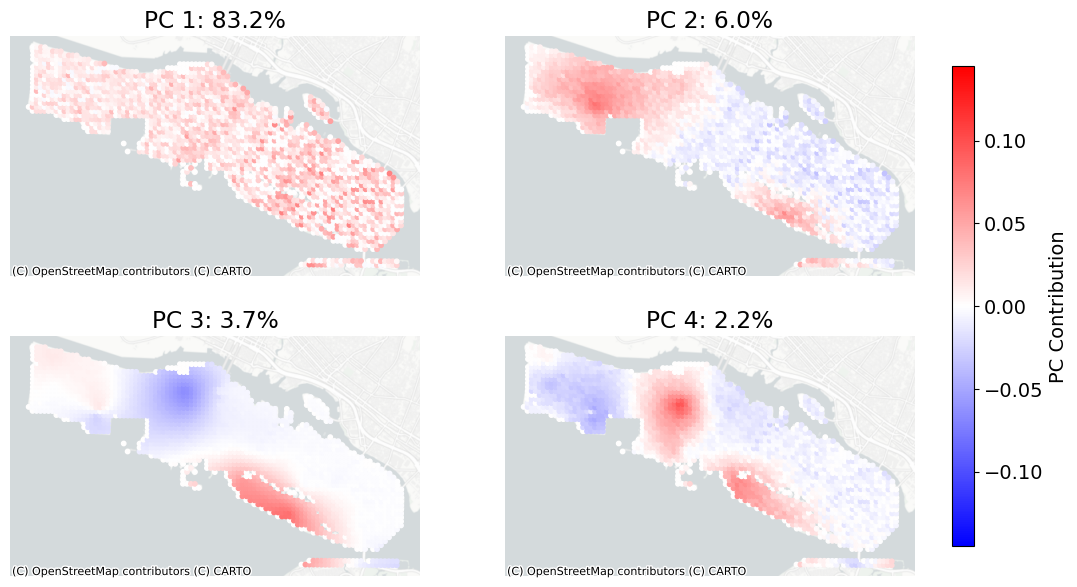

In [9]:
# Create the subplots
fig = plt.figure(figsize=(11, 6))
plt.rcParams.update({'font.size': 14})

# Define custom axes positions
axes_positions = [
    [0.05, 0.55, 0.4, 0.4],  # Top-left
    [0.50, 0.55, 0.4, 0.4],  # Top-right
    [0.05, 0.05, 0.4, 0.4],  # Bottom-left
    [0.50, 0.05, 0.4, 0.4]   # Bottom-right
]

axes = [fig.add_axes(pos) for pos in axes_positions]  # Create axes manually

num_pcs_to_plot = 4  # First 4 PCs

# Plot each PC's contribution
for i in range(num_pcs_to_plot):
    ax = axes[i]
    points.plot(
        column=f'PC_{i + 1}', 
        ax=ax, 
        cmap='bwr', 
        legend=False, 
        vmin=vmin, 
        vmax=vmax, 
        markersize=10
    )
    ctx.add_basemap(ax, crs=points.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
    ax.set_title(f'PC {i + 1}: {explained_variance[i]*100:.1f}%')
    ax.axis('off')


# Add a shared colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust the colorbar position
cbar = mpl.colorbar.ColorbarBase(
    cbar_ax, 
    cmap='bwr', 
    norm=norm, 
    orientation='vertical', 
    label='PC Contribution'
)

plt.tight_layout()
# plt.savefig('./figures/pc_maps.png', format='png', dpi=1000)
# plt.savefig('./figures/pc_maps.pdf', format='pdf', dpi=1000)

plt.show()


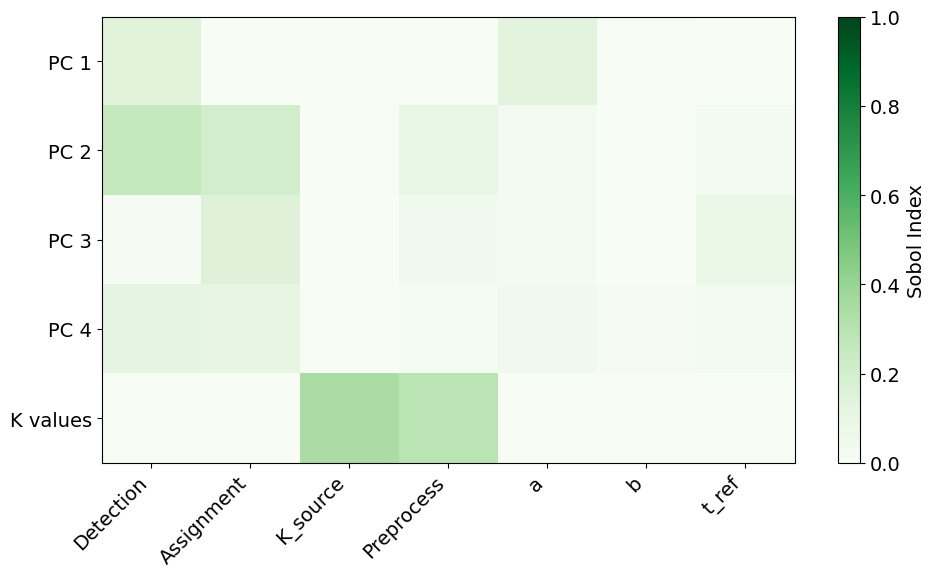

In [10]:
# run the same sensitivity for the K values
K_df = pd.read_csv('./from_sherlock/new_20250226/sensitivity_save_K_new.csv', index_col=0)
Y_k = (K_df['hk_m_day_0'].values - np.mean(K_df['hk_m_day_0'].values))/ np.std(K_df['hk_m_day_0'].values)  #np.log

Si_k   = sobol.analyze(problem, Y_k,calc_second_order=True)

## append with si_K and plot
Si_list = S1_matrix.tolist()
Si_list.append(Si_k['S1'])
S1_matrix = np.array(Si_list)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(S1_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(num_pcs+1))
ax.set_yticklabels([f'PC {i+1}' for i in range(num_pcs)] + ['K values'])
fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')

# Add overall title
# fig.suptitle('Sobol Indices', fontsize=16)
plt.tight_layout()
plt.show()

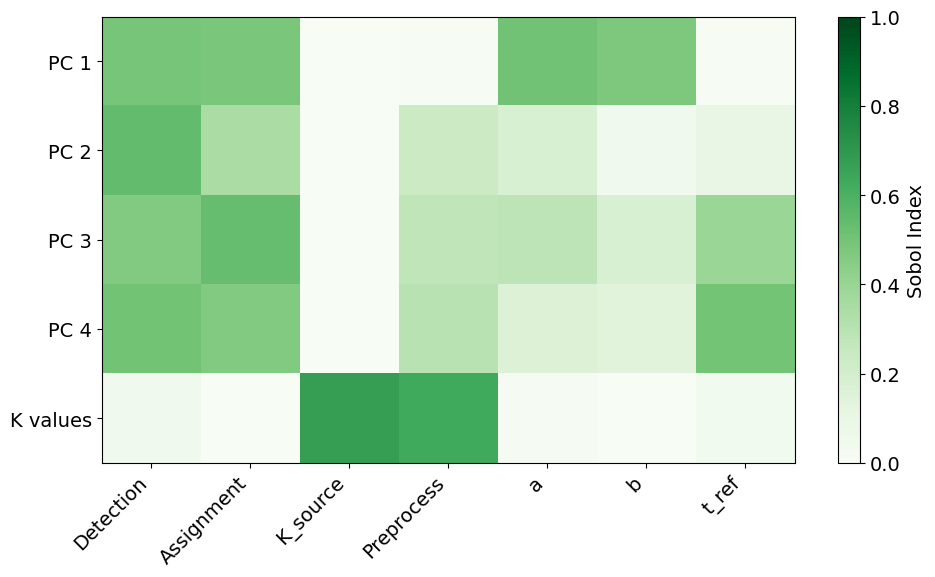

In [11]:
## Plot the higher order sobol for PCs and K
ST_matrix = np.array([Si['ST'] for Si in results])  # Shape: (num_pcs, num_vars)
ST_list = ST_matrix.tolist()
ST_list.append(Si_k['ST'])
ST_matrix = np.array(ST_list)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(ST_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(num_pcs+1))
ax.set_yticklabels([f'PC {i+1}' for i in range(num_pcs)] + ['K values'])
fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')

# Add overall title
# fig.suptitle('Sobol Indices', fontsize=16)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, '(b)')

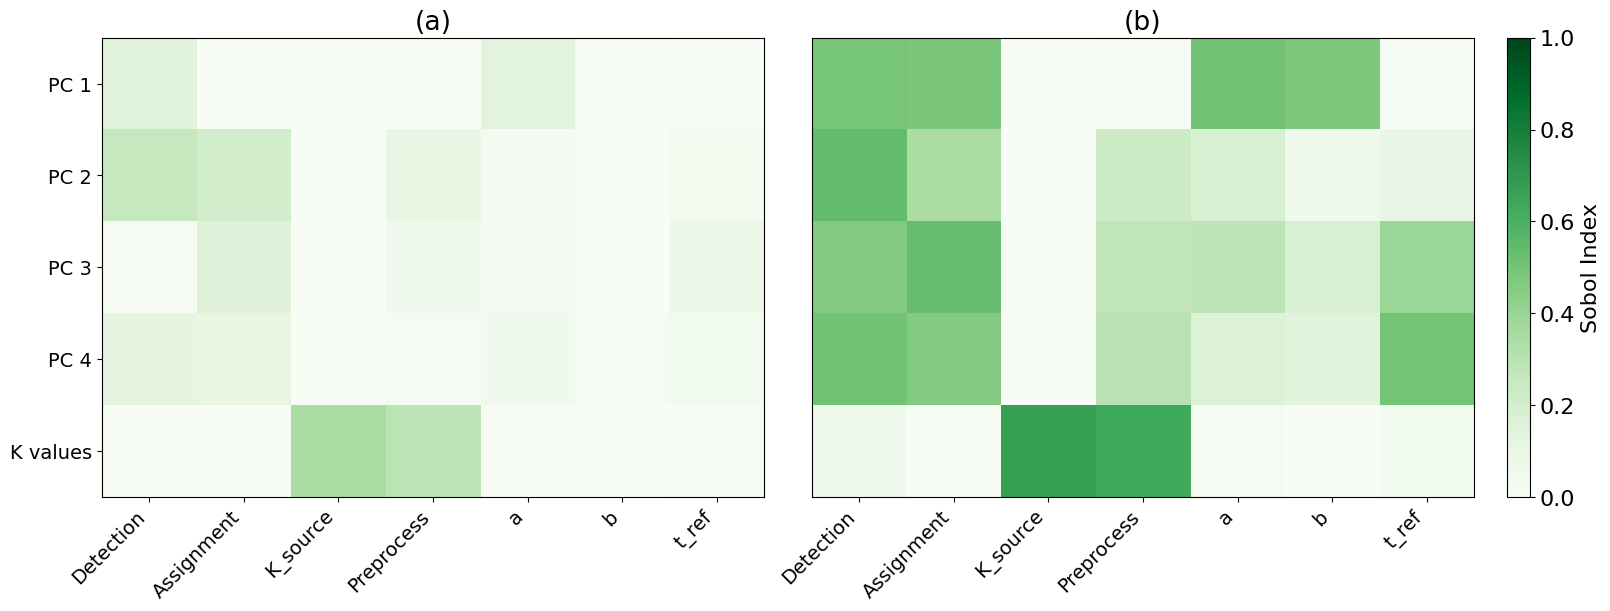

In [12]:
## make a plot with two side-by side subfigures that are s1 and sT
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
plt.rcParams.update({'font.size': 16})
axes = axes.flatten()
ax = axes[0]
im = ax.imshow(S1_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(num_pcs+1))
ax.set_yticklabels([f'PC {i+1}' for i in range(num_pcs)] + ['K values'])
# fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(a)')

ax = axes[1]
im = ax.imshow(ST_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
# remove y ticks
ax.set_yticks([])
fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(b)')
# plt.savefig('./figures/sobol_indices.png', format='png', dpi=1000,bbox_inches='tight')
# plt.savefig('./figures/sobol_indices.pdf', format='pdf', dpi=1000,bbox_inches='tight')


In [13]:
## Now running sensitivity on young bay mud values

pca = PCA()
pca.fit(ybm)

# find where the explained variance is 95%
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

# # Assume `outputs` is the spatial output matrix with shape (N, 2430)
pca = PCA(n_components=max(d,3))  # This is over 95% of the variance
ybm_pca = pca.fit_transform(ybm)  # Transformed output: shape (N, 16)

# Explained variance for each component
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", np.sum(explained_variance))
print("Explained variance ratio:", explained_variance)


Y_t = ybm_pca
Si_0   = sobol.analyze(problem, Y_t[:,0])

results = []
for i in range(d):
    Si = sobol.analyze(problem, Y_t[:, i])
    results.append(Si)
# Prepare data for the heatmap
num_pcs = len(results)  # Number of PCs
num_vars = len(problem['names'])  # Number of variables
S1_matrix = np.array([Si['S1'] for Si in results])  # Shape: (num_pcs, num_vars)


2
Explained variance ratio: 0.9938288984610528
Explained variance ratio: [0.81420106 0.17115116 0.00847668]


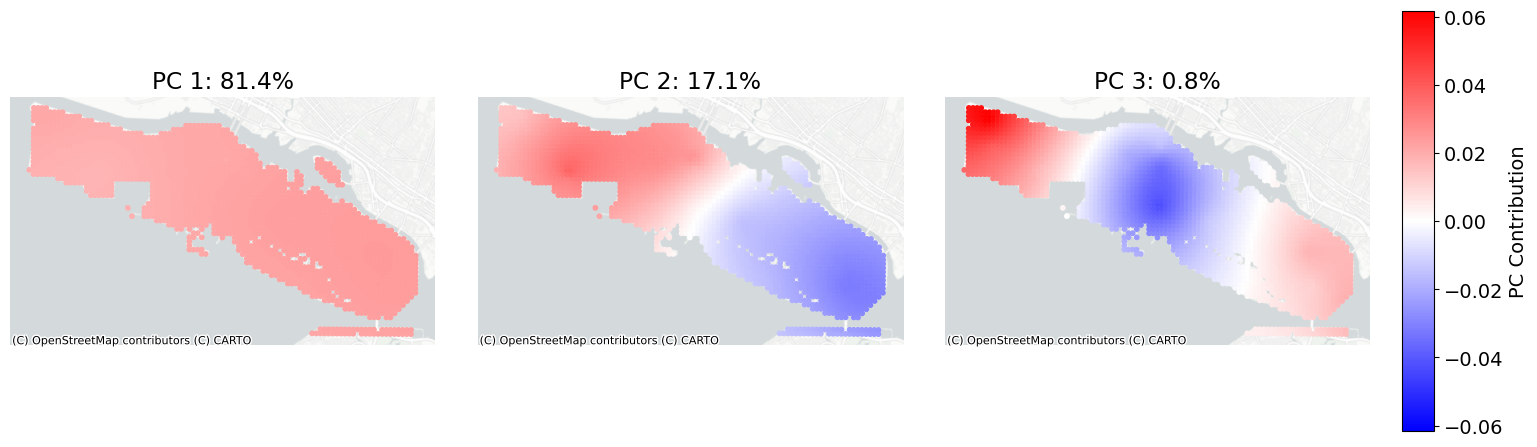

In [14]:
# plot the PCs for young bay mud
points = setup_grid(geoplot='./geojson/alameda_city.geojson')
points = points.to_crs('EPSG:4326')
loadings = pca.components_.T  # Shape: (n_points, n_pcs)
num_pcs_to_plot = 3  # First 6 PCs
for i in range(num_pcs_to_plot):
    points[f'PC_{i + 1}'] = loadings[:, i]

vmin = -max(abs(points[[f'PC_{i + 1}' for i in range(num_pcs_to_plot)]].min().min()),points[[f'PC_{i + 1}' for i in range(num_pcs_to_plot)]].max().max())
vmax = -vmin  # Symmetric around 0

fig, axes = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=False)
plt.rcParams.update({'font.size': 14})
axes = axes.flatten()

# Plot each PC's contribution
for i in range(num_pcs_to_plot):
    ax = axes[i]
    points.plot(
        column=f'PC_{i + 1}', 
        ax=ax, 
        cmap='bwr', 
        legend=False, 
        vmin=vmin, 
        vmax=vmax, 
        markersize=10
    )
    ctx.add_basemap(ax, crs=points.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
    ax.set_title(f'PC {i + 1}: {explained_variance[i]*100:.1f}%')
    ax.axis('off')

# Add a shared colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the colorbar position
cbar = mpl.colorbar.ColorbarBase(
    cbar_ax, 
    cmap='bwr', 
    norm=norm, 
    orientation='vertical', 
    label='PC Contribution'
)

# Adjust spacing between subplots and margins
plt.subplots_adjust(
    left=0.05,  # Left margin
    right=0.9,  # Reserve space for the colorbar
    top=0.9,    # Top margin
    bottom=0.1, # Bottom margin
    wspace=0.1, # Space between columns
    hspace=0.05  # Space between rows
)

Text(0.5, 1.0, '(b)')

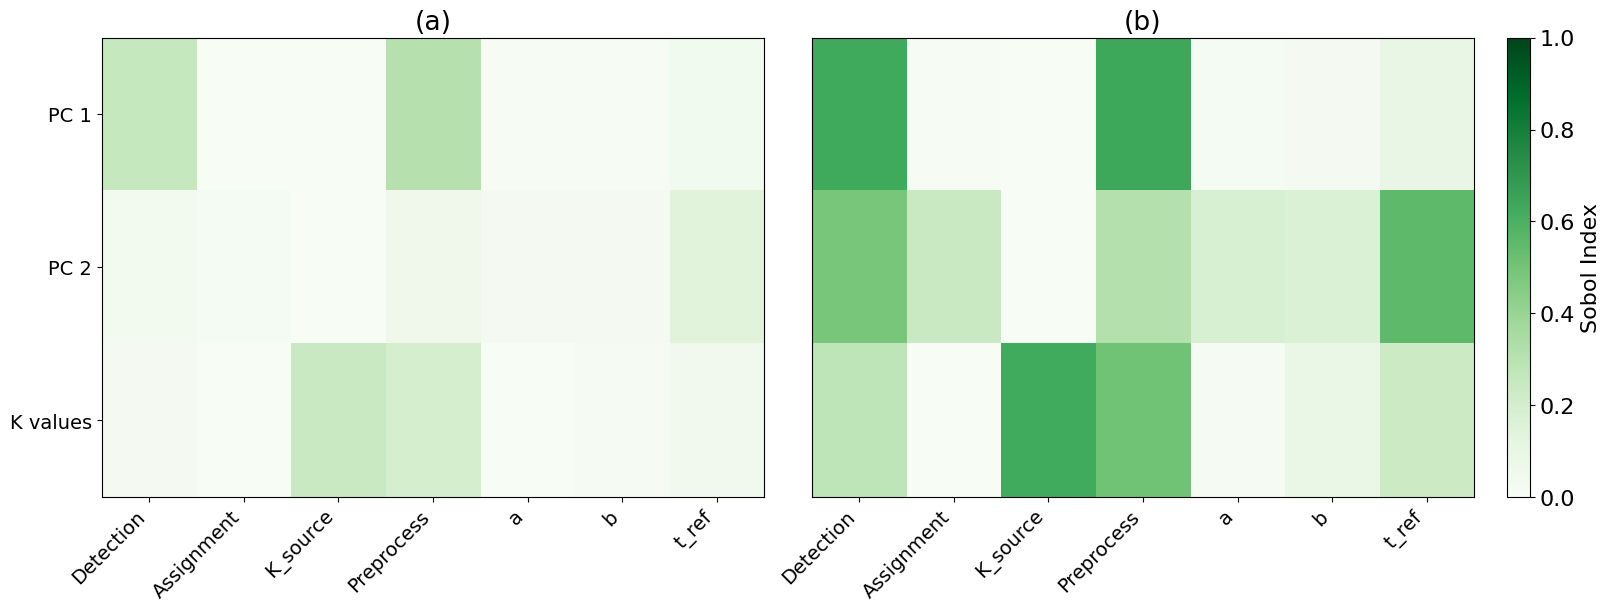

In [15]:
Y_k = (K_df['hk_m_day_1'].values - np.mean(K_df['hk_m_day_1'].values))/ np.std(K_df['hk_m_day_1'].values)  #np.log

Si_k   = sobol.analyze(problem, Y_k)

## append with si_K and plot
Si_list = S1_matrix.tolist()
Si_list.append(Si_k['S1'])
S1_matrix = np.array(Si_list)
## Plot the higher order sobol for PCs and K
ST_matrix = np.array([Si['ST'] for Si in results])  # Shape: (num_pcs, num_vars)
ST_list = ST_matrix.tolist()
ST_list.append(Si_k['ST'])
ST_matrix = np.array(ST_list)

## make a plot with two side-by side subfigures that are s1 and sT
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
plt.rcParams.update({'font.size': 16})
axes = axes.flatten()
ax = axes[0]
im = ax.imshow(S1_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(num_pcs+1))
ax.set_yticklabels([f'PC {i+1}' for i in range(num_pcs)] + ['K values'])
# fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(a)')

ax = axes[1]
im = ax.imshow(ST_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
# remove y ticks
ax.set_yticks([])
fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(b)')
# plt.savefig('./figures/sobol_indices.png', format='png', dpi=1000,bbox_inches='tight')
# plt.savefig('./figures/sobol_indices.pdf', format='pdf', dpi=1000,bbox_inches='tight')


##### Finally, combine the sensitivity for K/fill/young bay mud

Text(0.5, 1.0, '(b)')

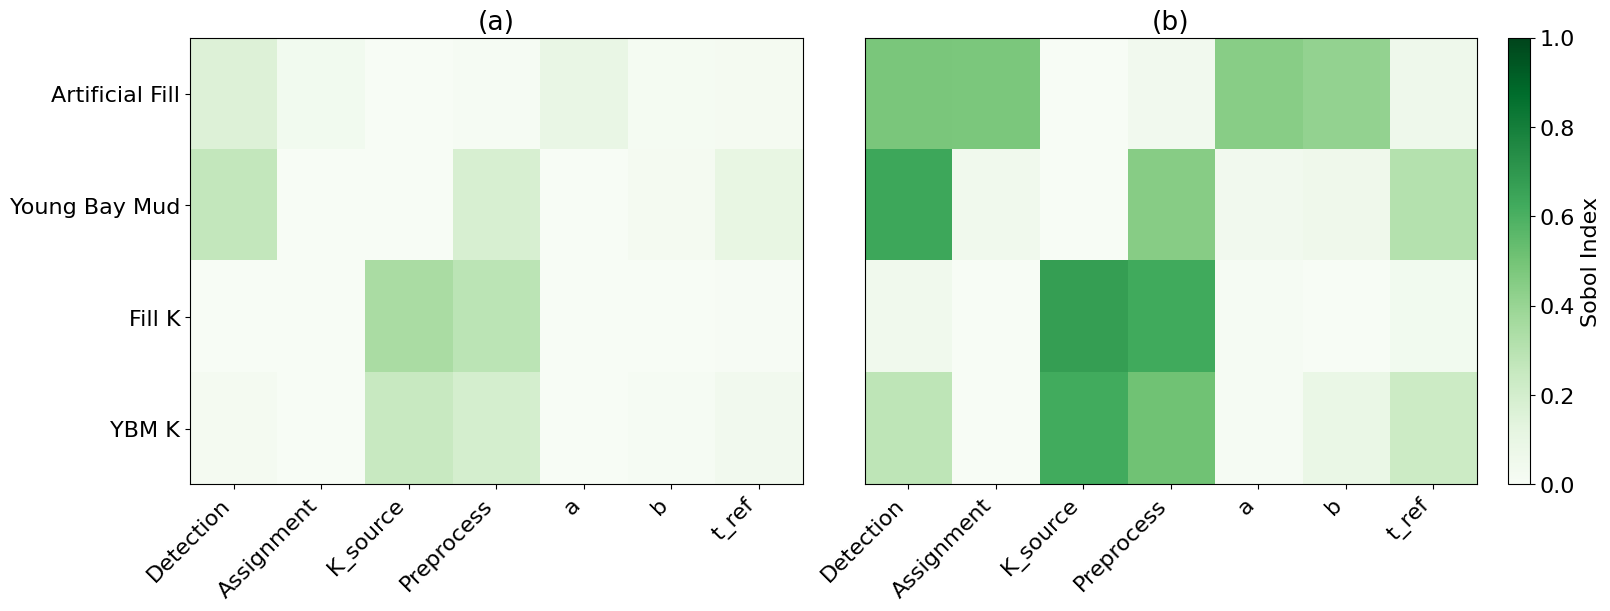

In [16]:
y_fill = np.sum(fill_pca[:,:4],axis=1)
y_ybm = np.sum(ybm_pca[:,:2],axis=1)
y_k_fill = (K_df['hk_m_day_0'].values - np.mean(K_df['hk_m_day_0'].values))/ np.std(K_df['hk_m_day_0'].values)  #np.log
y_k_ybm = (K_df['hk_m_day_1'].values - np.mean(K_df['hk_m_day_1'].values))/ np.std(K_df['hk_m_day_1'].values)  #np.log

Si_fill   = sobol.analyze(problem, y_fill,calc_second_order=True)
Si_ybm   = sobol.analyze(problem, y_ybm,calc_second_order=True)
Si_k_fill   = sobol.analyze(problem, y_k_fill,calc_second_order=True)
Si_k_ybm   = sobol.analyze(problem, y_k_ybm,calc_second_order=True)

## append them all together and plot
S1_matrix = np.array([Si_fill['S1'], Si_ybm['S1'], Si_k_fill['S1'], Si_k_ybm['S1']])
ST_matrix = np.array([Si_fill['ST'], Si_ybm['ST'], Si_k_fill['ST'], Si_k_ybm['ST']])
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
plt.rcParams.update({'font.size': 16})
axes = axes.flatten()
ax = axes[0]
im = ax.imshow(S1_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_yticks(range(4))
ax.set_yticklabels(['Artificial Fill', 'Young Bay Mud', 'Fill K', 'YBM K'])
# fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(a)')
ax = axes[1]
im = ax.imshow(ST_matrix, aspect='auto', cmap='Greens', interpolation='nearest', vmin=0,vmax=1)
ax.set_xticks(range(num_vars))
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
# remove y ticks
ax.set_yticks([])
fig.colorbar(im, ax=ax, orientation='vertical', label='Sobol Index')
ax.set_title('(b)')
# plt.savefig('./figures/sobol_indices.png', format='png', dpi=1000,bbox_inches='tight')
# plt.savefig('./figures/sobol_indices.pdf', format='pdf', dpi=1000,bbox_inches='tight')